In [41]:
#Custom Data Loading Function
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
 
class CustomCelebADataset(Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root
        self.transform = transform
        # Paths to metadata files
        attr_path = os.path.join(root, 'celeba', 'list_attr_celeba.txt')
        split_path = os.path.join(root, 'celeba', 'list_eval_partition.txt')
        img_folder = os.path.join(root, 'celeba', 'img_align_celeba')
 
        # Load labels
        with open(attr_path) as f:
            lines = f.readlines()
            header = lines[1].strip().split()
            data = [line.strip().split() for line in lines[2:]]
        self.attr_names = header
        df_attr = pd.DataFrame(data)
        df_attr.columns = ['filename'] + header
        df_attr[header] = df_attr[header].astype(int)
        df_attr[header] = (df_attr[header] == 1).astype(int)  # convert -1 to 0
 
        # Load split info
        df_split = pd.read_csv(split_path, delim_whitespace=True, header=None, names=['filename', 'split'])
 
        # Merge and filter by split
        df = pd.merge(df_attr, df_split, on='filename')
        split_map = {'train': 0, 'valid': 1, 'test': 2}
        self.df = df[df['split'] == split_map[split]].reset_index(drop=True)
 
        self.img_folder = img_folder
 
    def __len__(self):
        return len(self.df)
 
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_folder, row['filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(row[self.attr_names].values.astype('float32'))
        return image, labels

In [43]:
#Resizing
from torchvision import transforms
from torch.utils.data import DataLoader
 
# Transform for classical models (flattened)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten to 12288-dim
])
 
dataset = CustomCelebADataset(
    root='/Users/momin/Downloads/data',
    split='train',
    transform=transform
)
 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

/var/folders/xs/hltg9ns15bz5zf9zdfzczcc80000gn/T/ipykernel_39839/2575843758.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_split = pd.read_csv(split_path, delim_whitespace=True, header=None, names=['filename', 'split'])


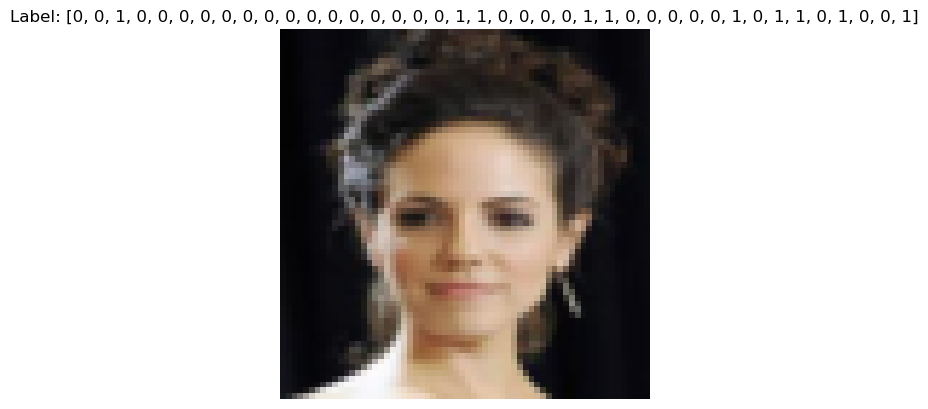

In [45]:
import matplotlib.pyplot as plt
 
# Get one batch
images, labels = next(iter(dataloader))
 
# For flattened input (Logistic/LDA), reshape for viewing
img = images[0].view(3, 64, 64).permute(1, 2, 0)  # HWC format
plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {labels[0].int().tolist()}")
plt.show()


In [47]:
#Standardization
import numpy as np
from sklearn.preprocessing import StandardScaler
 
# Step 1: Extract all (image, label) pairs into full arrays
X_list = []
Y_list = []
 
for img, label in dataset:
    X_list.append(img.numpy())        # already flattened by transform
    Y_list.append(label.numpy())      # 40-dim binary vector
 
X = np.stack(X_list)  # shape: (n_samples, 12288)
Y = np.stack(Y_list)  # shape: (n_samples, 40)
 
print("Shapes - X:", X.shape, "Y:", Y.shape)

Shapes - X: (5000, 12288) Y: (5000, 40)


In [49]:
# Step 2: Standardize features (mean 0, std 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
 
print("Standardization complete. Mean:", np.mean(X_scaled), "Std:", np.std(X_scaled))

Standardization complete. Mean: 7.2638193e-09 Std: 0.99999917


In [51]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
)

# 1) Load train + validation splits
train_ds = CustomCelebADataset(
    root='/Users/momin/Downloads/data',
    split='train',
    transform=transform
)
val_ds = CustomCelebADataset(
    root='/Users/momin/Downloads/data',
    split='valid',
    transform=transform
)

# 2) Extract X (flattened) and Y (labels) arrays
def extract_XY(ds):
    X_list, Y_list = [], []
    for img, lbl in ds:
        X_list.append(img.numpy())
        Y_list.append(lbl.numpy())
    return np.stack(X_list), np.stack(Y_list)

X_train, Y_train = extract_XY(train_ds)
X_val,   Y_val   = extract_XY(val_ds)

print("Train shapes:", X_train.shape, Y_train.shape)
print("Val   shapes:", X_val.shape,   Y_val.shape)

# 3) Standardize features
scaler      = StandardScaler()
X_train_s   = scaler.fit_transform(X_train)
X_val_s     = scaler.transform(X_val)

/var/folders/xs/hltg9ns15bz5zf9zdfzczcc80000gn/T/ipykernel_39839/2575843758.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_split = pd.read_csv(split_path, delim_whitespace=True, header=None, names=['filename', 'split'])
/var/folders/xs/hltg9ns15bz5zf9zdfzczcc80000gn/T/ipykernel_39839/2575843758.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_split = pd.read_csv(split_path, delim_whitespace=True, header=None, names=['filename', 'split'])


Train shapes: (5000, 12288) (5000, 40)
Val   shapes: (1000, 12288) (1000, 40)


In [53]:
from sklearn.decomposition import PCA

# 4) PCA — e.g. to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_s)
X_val_pca   = pca.transform(X_val_s)

# Inspect how many components were kept and the total explained variance
print("Original feature dim:", X_train_s.shape[1])
print("Reduced feature dim:",  X_train_pca.shape[1])
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

Original feature dim: 12288
Reduced feature dim: 264
Total explained variance: 0.9501


In [65]:
from sklearn.model_selection import GridSearchCV

# 1) Define a grid of C values to try
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# 2) Base classifier
base_clf = LinearSVC(random_state=42, max_iter=10000)

# 3) Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring='roc_auc',   # optimize for AUC on CV folds
    cv=5,
    n_jobs=-1,
    refit=True           # automatically refit the best model on full training set
)

# 4) Run the grid search
grid_search.fit(X_train_pca, y_train)

# 5) Inspect best hyperparameter and CV score
best_C     = grid_search.best_params_['C']
best_cv_auc = grid_search.best_score_
print(f"Best C: {best_C} | Best CV AUC: {best_cv_auc:.3f}")

# 6) Evaluate the best estimator on your validation split
best_clf = grid_search.best_estimator_
y_pred   = best_clf.predict(X_val_pca)
y_score  = best_clf.decision_function(X_val_pca)

# 7) Compute the full suite of metrics
acc       = accuracy_score(y_val, y_pred)
f1        = f1_score(y_val, y_pred)
auc       = roc_auc_score(y_val, y_score)
recall    = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)

print(
    f"{attr:10s} | "
    f"acc: {acc:.3f} | "
    f"F1: {f1:.3f} | "
    f"AUC: {auc:.3f} | "
    f"recall: {recall:.3f} | "
    f"precision: {precision:.3f}"
)

Best C: 0.001 | Best CV AUC: 0.942
Smiling    | acc: 0.879 | F1: 0.874 | AUC: 0.950 | recall: 0.873 | precision: 0.875


In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score
)

# 1) Define parameter grid
param_grid = {
    'C':     [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

# 2) Base RBF‐kernel SVM
base_svc = SVC(
    kernel='rbf',
    probability=False,  # decision_function for AUC
    random_state=42
)

# 3) Grid search setup
grid = GridSearchCV(
    estimator=base_svc,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    refit=True
)

# 4) Fit on training data
grid.fit(X_train_pca, y_train)

# 5) Best hyperparameters
best_C     = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']
best_cv_auc = grid.best_score_
print(f"Best C: {best_C} | Best gamma: {best_gamma} | CV AUC: {best_cv_auc:.3f}")

# 6) Evaluate on validation set
best_svc = grid.best_estimator_
y_pred   = best_svc.predict(X_val_pca)
y_score  = best_svc.decision_function(X_val_pca)

# 7) Compute metrics
acc       = accuracy_score(y_val, y_pred)
f1        = f1_score(y_val, y_pred)
auc       = roc_auc_score(y_val, y_score)
recall    = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)

print(
    f"{attr:10s} | RBF SVM | "
    f"acc: {acc:.3f} | "
    f"F1: {f1:.3f} | "
    f"AUC: {auc:.3f} | "
    f"recall: {recall:.3f} | "
    f"precision: {precision:.3f}")

Best C: 1 | Best gamma: scale | CV AUC: 0.931
Smiling    | RBF SVM | acc: 0.868 | F1: 0.856 | AUC: 0.943 | recall: 0.815 | precision: 0.901


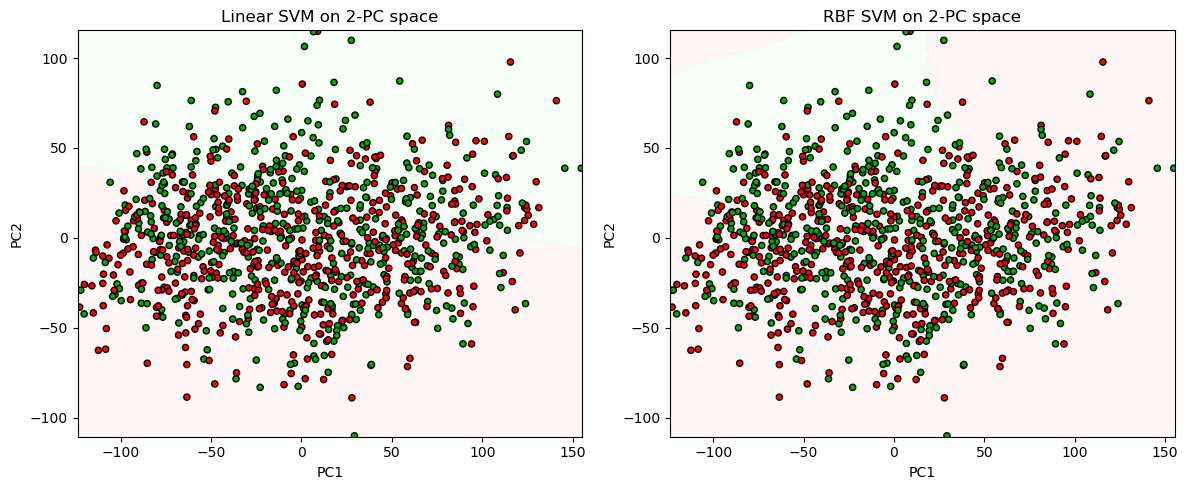

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC

# 1) Prepare 2D PCA projections
pca2 = PCA(n_components=2, random_state=42)
X_train_2 = pca2.fit_transform(X_train_s)
X_val_2   = pca2.transform(X_val_s)

# pick the attribute
attr = 'Smiling'
idx  = train_ds.attr_names.index(attr)
y_tr = Y_train[:, idx]
y_va = Y_val[:,   idx]

# 2) Fit classifiers on the 2D PCA data
clf_lin = LinearSVC(random_state=42, max_iter=10000).fit(X_train_2, y_tr)
clf_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42).fit(X_train_2, y_tr)

# 3) Utility to plot decision regions
def plot_decision(ax, model, X, y, title):
    # create grid
    x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
    y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contour fill
    cmap_bg = ListedColormap(['#FFEEEE','#EEFFEE'])
    ax.contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.5)
    
    # scatter validation points
    cmap_pts = ListedColormap(['#FF0000','#00AA00'])
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap_pts, edgecolor='k', s=20)
    
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# 4) Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_decision(ax1, clf_lin, X_val_2, y_va, 'Linear SVM on 2‐PC space')
plot_decision(ax2, clf_rbf, X_val_2, y_va, 'RBF SVM on 2‐PC space')
plt.tight_layout()
plt.show()

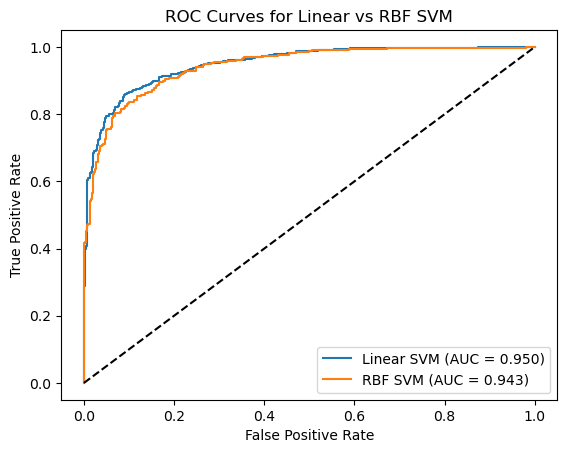

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute decision scores
y_score_lin = best_clf.decision_function(X_val_pca)
y_score_rbf = best_svc.decision_function(X_val_pca)

# Compute ROC curve and AUC for Linear SVM
fpr_lin, tpr_lin, _ = roc_curve(y_val, y_score_lin)
roc_auc_lin = auc(fpr_lin, tpr_lin)

# Compute ROC curve and AUC for RBF SVM
fpr_rbf, tpr_rbf, _ = roc_curve(y_val, y_score_rbf)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

# Plotting
plt.figure()
plt.plot(fpr_lin, tpr_lin, label=f'Linear SVM (AUC = {roc_auc_lin:.3f})')
plt.plot(fpr_rbf, tpr_rbf, label=f'RBF SVM (AUC = {roc_auc_rbf:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Linear vs RBF SVM')
plt.legend(loc='lower right')
plt.show()
